In [1]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random
import time
from tqdm import trange
from stardate.lhf import gk_rotation_model
import stardate
from itertools import product

mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)

def genErr(dv, dv_err):
    errorRand=np.random.normal(0, 1, len(dv))
    return dv+dv_err*errorRand


# get average ages
def getAveAges(df,fs,binfs,vz='v_b'):
    min_star=15
    max_star=30
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """        
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    iso_age=df['iso_age'].values
    iso_age_err=df['iso_age_err1'].values
    
    iso_ave=np.zeros(len(df))
    iso_ave_err=np.zeros(len(df))
    
    vels=df[vz].values
    kin_age=np.zeros(len(df))
            
            
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        
        binfs_new=binfs
        while sum(mask)<min_star:
            if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*1.1 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            
            
        iso_age_single=iso_age[mask]
        iso_age_err_single=iso_age_err[mask]
        
        weights=1/np.power(iso_age_err_single,2)
        iso_ave[i]=sum((iso_age_single*weights)/sum(weights))
        iso_ave_err[i]=np.std(iso_age_err_single)
        
        vels_single=vels[mask]
        
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['vel_dis']=kin_age
    df['iso_age_ave']=iso_ave
    df['iso_age_ave_err']=iso_ave_err
    return v_to_age(kin_age,p_mr),iso_ave,iso_ave_err

import time
from tqdm import trange
# get average ages
def getkinAges(df,fs,binfs,min_star=5,max_star=30,vz='v_b'):
    countsNo=0
    df=df.reset_index(drop=True)
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """        
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    vels=df[vz].values
    kin_age=np.zeros(len(df))
        

    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        vels_single=vels[mask]
        
        binfs_new=binfs
        switch=0
        while len(vels_single)<min_star:
            if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*1.1 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            switch=1
            
        while len(vels_single)>max_star:
            if any([binfs_new[jj]<binfs[jj]/2 for jj in range(len(binfs))]):
                    break
            binfs_new=[i*0.9 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            switch=1
            
        if switch==1:
            countsNo=countsNo+1
        
                
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
                
                
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['vel_dis']=kin_age
    df['kin_age']=v_to_age(kin_age,p_mr)
    print(countsNo)
    return kin_age,v_to_age(kin_age,p_mr)

    

# get average ages
def getkinAges_err(df,fs,fs_err,binfs,min_star=5,max_star=30,sampsize=50,vz='v_b',vz_err='v_b_err'):
    # generate new data
    newDatas=np.zeros((len(df),len(fs),sampsize))
    
    ages=np.zeros((len(df),sampsize))
    
    for i in range(len(fs)):
        if 'Prot' in fs[i]:
            newDatas[:,i,:]=np.log10(getErr(df[fs[i]],df[fs_err[i]],sampsize))
        else:
            newDatas[:,i,:]=getErr(df[fs[i]],df[fs_err[i]],sampsize)
    
    # generate new vb data
    newVbs=np.zeros((len(df),sampsize))
    newVbs=getErr(df[vz],df[vz+'_err'],sampsize)
    
    newfs=[i+'_new' for i in fs]
    for i in range(sampsize):
        print(i/sampsize)
        for j in range(len(fs)):
            df[newfs[j]]=newDatas[:,j,i]
        df[vz+'_new']=newVbs[:,i]
        _,ages[:,i]=getkinAges(df,newfs,binfs,vz=vz+'_new',min_star=min_star)
    return ages




def getVs(px,pmra,pmdec,ra,dec):
    """ Calculates tangential velocity (v_tan) and vertical velocity proximation (v_b).
    
    Args:
      df ([Pandas DataFrame]): DataFrame contains columns 'parallax', 'pmra', 'pmdec', 'ra', 'dec', which are parallax, ra proper motion, dec propermotion, right ascension and declination, respectively  
    
    Returns:
      :v_t ([array-like]): Tangential velocity
      :v_b ([array-like]): Proxy for vertical velocity
    """
    d = coord.Distance(parallax=np.array(px) * u.mas,allow_negative=True)
    vra = (np.array(pmra)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    vdec = (np.array(pmdec)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    v_t=np.sqrt(np.power(vra,2.)+np.power(vdec,2.)) # vtan
    # v_b as a proxy for v_z:
    c = coord.SkyCoord(ra=np.array(ra)*u.deg, dec=np.array(dec)*u.deg, distance=d,
                  pm_ra_cosdec=np.array(pmra)*u.mas/u.yr,
                  pm_dec=np.array(pmdec)*u.mas/u.yr)
    gal = c.galactic
    v_b = (gal.pm_b * gal.distance).to(u.km/u.s, u.dimensionless_angles()) # vb
    return v_t,v_b

def getErr(x,x_errs,numb):
    newX=np.zeros((len(x),numb))
    for i in range(len(x)):
        newX[i,:]=np.random.normal(x[i], x_errs[i], numb)
    return newX

def getDust(G, bp, rp, ebv, maxnit=100):
    """
    Compute the Gaia extinctions assuming relations from Babusieux.
    Author: Sergey Koposov skoposov@cmu.edu
    Args:
        G (float): Gaia G mag.
        bp (float): Gaia BP mag.
        rp (float): Gaia RP mag.
        ebv (float): E(B-V), extinction in B-V.
        maxnit (int): number of iterations
    Returns:
        Extinction in G,bp, rp
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        curbp = curbp1

    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp


def bprp_to_teff(bprp):
    """
    Calculate photometric Teff from Gaia color (use dereddened color!)
    Args:
        bprp (array): Gaia G_BP colour minus Gaia G_RP colour.
    Returns:
        teffs (array): Photometric effective temperatures.
    """

    coeffs = [8959.8112335205078, -4801.5566310882568, 1931.4756631851196,
            -2445.9980716705322, 2669.0248055458069, -1324.0671020746231,
            301.13205924630165, -25.923997443169355]
    """
    # Jason's updated parameters:
    coeffs = [-416.585, 39780.0, -84190.5, 85203.9, -48225.9, 15598.5,
              -2694.76, 192.865]
    """

    return np.polyval(coeffs[::-1], bprp)


def bv_to_teff(BV):
    BV=np.array(BV)
    #return np.power(BV+0.4,-2./3.)*5601.
    return 5000.*(np.power(0.92*BV+1.7,-1.)+np.power(0.92*BV+0.62,-1.))

def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(D)-10

def optimizeBins(df,df_match,fs,binmin,binmax,min_star=5,max_star=30,df_match_name='age',df_match_name_err='age_err',vz='v_b',bintestNo=10,errVals=False):

    df=df.dropna(subset=np.append([vz],fs)).reset_index(drop=True)
    p_mp, p_mr, p_a = get_avr_coefficients()
    
    df=df.reset_index(drop=True)
    
    if errVals:
        df_common=pd.merge(df[np.append(['KID','kin_age_err'],fs)],df_match[['KID',df_match_name,df_match_name_err]],left_on='KID',right_on='KID',how='inner')[['KID',df_match_name,df_match_name_err,'kin_age_err']]
        df_common.dropna(subset=['kin_age_err'])
    else:                                                                             
        df_common=pd.merge(df[np.append(['KID'],fs)],df_match,left_on='KID',right_on='KID',how='inner')[['KID',df_match_name,df_match_name_err]]
    
    commonKID=df_common['KID'].values
    
    fslen=len(fs)
    dflen=len(commonKID)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((len(df),fslen))
    
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """    
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    KIDs=df['KID'].values
    
    vels=df[vz].values
    kin_age=np.zeros(len(commonKID))
    No_stars=np.zeros(len(commonKID))
    
    binfs=np.zeros((fslen,bintestNo))
    
    for k in range(fslen):
        binfs[k,:]=np.linspace(binmin[k],binmax[k],bintestNo)
    
    
    testbins=[]
    
    sums=''
    a=['i'+str(i)+',' for i in range(fslen)]
    for i in a:
        sums=sums+i
    
    for a in product(range(bintestNo), repeat=len(a)):
        evalint=[binfs[j,a[j]] for j in range(len(a))]
        #print(evalint)
        testbins.append(evalint)

    
    # optimization
    count=0
    
    for k in trange(len(testbins)):
        binfs=testbins[k]
        for i in range(len(commonKID)):
            ind=np.where(KIDs==commonKID[i])

            mask=np.ones(len(df), dtype=bool)
        
            for j in range(fslen):
                checkpara[j]=paras[ind,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2.)
            vels_single=vels[mask]
            
            binfs_new=binfs
        
            
            while len(vels_single)<min_star:
                if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
                #print([binfs_new[jj]>1.5*binfs[jj] for jj in range(len(binfs))])
                binfs_new=[ii*1.1 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras[ind,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
                
            while len(vels_single)>max_star:
                if any([binfs_new[jj]<binfs[jj]/2 for jj in range(len(binfs))]):
                    break
                #print([binfs_new[jj]>1.5*binfs[jj] for jj in range(len(binfs))])
                binfs_new=[ii*0.9 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras[ind,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
            
            kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
            No_stars[i]=len(vels_single)
        
        df_common['veldisp']=kin_age
        df_common['kin_age']=v_to_age(df_common['veldisp'],p_mr)
        
        kinages = df_common['kin_age'].values
        m = (kinages!=kinages)
        kinages[m] = -99999
        df_common['kin_age'] = kinages
        df_test = df_common
        
        
        if count==0:
            if errVals:
                sigma=df_test[df_match_name_err]**2+df_test['kin_age_err']**2
                chisq=sum(((df_test[df_match_name]-df_test['kin_age'])**2./sigma))/len(df_test)
            else:
                chisq=sum(((df_test[df_match_name]-df_test['kin_age'])**2./np.power(df_test[df_match_name_err],2.)))/len(df_test)
            df_best=df_test
            opt_binsize=binfs
            count=count+1
        else:
            if errVals:
                sigma=df_test[df_match_name_err]**2+df_test['kin_age_err']**2
                chisq_new=sum(((df_test[df_match_name]-df_test['kin_age'])**2./sigma))/len(df_test)
            else:        
                chisq_new=sum(((df_test[df_match_name]-df_test['kin_age'])**2./np.power(df_test[df_match_name_err],2.)))/len(df_test)
            if chisq_new<chisq:
                opt_binsize=binfs
                chisq=chisq_new
                df_best=df_test
            count=count+1
        
    
    checkpara=np.zeros(fslen)
    
    for i in trange(len(commonKID)):
        ind=np.where(KIDs==commonKID[i])

        mask=np.ones(len(df), dtype=bool)
        """
        # subtract MS
        z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
           -3.54673368e-01,3.51882114e+02]
        p = np.poly1d(z)
        
        for i in range(len(fs)):
            if 'abs_G' in fs[i]:
                df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
                fs[i]='abs_G_sub'
        """    
        for j in range(fslen):
            checkpara[j]=paras[ind,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<opt_binsize[j]/2)

        vels_single=vels[mask]
        binfs_new=opt_binsize
            
            
        while len(vels_single)<min_star:
            if any([binfs_new[jj]>2*opt_binsize[jj] for jj in range(len(opt_binsize))]):
                break
            binfs_new=[ii*1.1 for ii in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[ind,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            #print(len(vels_single),binfs_new)
            
        vels_single=vels[mask]
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        No_stars[i]=len(vels_single)
            
    df_common['kin_age']=v_to_age(kin_age,p_mr)
    kinages = df_common['kin_age'].values
    m = (kinages!=kinages)
    kinages[m] = -999
    df_common['kin_age'] = kinages
        
    df_common['NumbStars']=No_stars
    df_common['measure_age']=df_common[df_match_name]
    df_common['measure_age_err']=df_common[df_match_name_err]

    if errVals:
        df_common['kin_age_err']=df_common['kin_age_err']
        return opt_binsize, df_common[['KID','kin_age','kin_age_err','measure_age','measure_age_err','NumbStars']],chisq
    else:
        return opt_binsize, df_common[['KID','kin_age','measure_age','measure_age_err','NumbStars']],chisq

    

        

def GetParaErrors(df,samp=1000):
    vts=np.zeros((len(df),samp))
    vbs=np.zeros((len(df),samp))
    px_s=getErr(df['parallax'].values,df['parallax_error'].values,samp)
    pmra_s=getErr(df['pmra'].values,df['pmra_error'].values,samp)
    pmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,samp)
    ra_s=getErr(df['ra'].values,df['ra_error'].values,samp)
    dec_s=getErr(df['dec'].values,df['dec_error'].values,samp)
    for i in trange(samp):
        vts[:,i],vbs[:,i]=getVs(px_s[:,i],pmra_s[:,i],pmdec_s[:,i],ra_s[:,i],dec_s[:,i])
    
    vt_err=np.zeros(len(df))
    vb_err=np.zeros(len(df))

    for i in trange(len(df)):
        vt_err[i]=np.std(vts[i,:])
        vb_err[i]=np.std(vbs[i,:])  
    
    df['v_t_err']=vt_err
    df['v_b_err']=vb_err

    absg_err=np.zeros((len(df),samp))

    px_s=getErr(df['parallax'].values,df['parallax_error'].values,samp)
    
    for i in trange(samp):
        absg_err[:,i]=m_to_M(df.phot_g_mean_mag.values, 1./px_s[:,i])


    absg_err_err=np.zeros(len(df))
    for i in trange(len(df)):
        absg_err_err[i]=np.std(absg_err[i,:])
    df['abs_G_err']=absg_err_err

    Ro_err=np.zeros((len(df),samp))
    mass_s=getErr(df['mass'].values,df['mass_err1'].values,samp)
    Prot_s=getErr(df['Prot'].values,df['Prot_err'].values,samp)
    
    for i in trange(samp):
        Ro_err[:,i]=Prot_s[:,0]/stardate.convective_overturn_time(mass_s[:,i])

    Ro_err_err=np.zeros(len(df))
    for i in trange(len(df)):
        Ro_err_err[i]=np.std(Ro_err[i,:])
    df['Ro_err']=Ro_err_err
    
    return df


def findstars(df,f1_star,f2_star,f3_star,f1='color_teffs',f2='Prot',f3='abs_G'):
    KIDs=np.zeros(len(f1_star))
    count=0
    for i in range(len(f1_star)):
        update_progress(i/len(f1_star))
        teff,prot,abs_g=f1_star[i],f2_star[i],f3_star[i]
        df['dist']=np.power(df[f1]-teff,2.)+np.power(df[f2]-prot,2.)+np.power(df[f3]-prot,2.)
        KIDs[count]=df.sort_values(by=['dist'])['KID'].iloc[0]
        count=count+1
    return KIDs


def countstars(df,fs,binfs):
    df=df.reset_index(drop=True)
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    starNo=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        
        starNo[i]=sum(mask)
    return starNo
        
    
def calcChi2(x,y,xerr,yerr):
    return sum(np.power(x-y,2)/(xerr**2.+yerr**2.)/len(x))

def calc_tc(teff):
    return 314.24*np.exp(-(teff/1952.5)-(teff/6250)**18)+0.002

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


# Read in activity data

In [494]:
activity = pd.read_csv('kepler_area_activity_and_velocities_bright.csv')

In [495]:
df = activity.loc[activity['color_teffs']>3000].reset_index(drop=True)
df.columns, len(df)


(Index(['Unnamed: 0', 'solution_id', 'designation', 'random_index', 'ref_epoch',
        'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
        ...
        'bprp_dered', 'G_dered', 'abs_G', 'color_teffs', 'vx', 'vy', 'vz', 'x',
        'y', 'z'],
       dtype='object', length=174),
 66309)

In [496]:
#activity['activityindex_espcs'].hist(bins=100)

# get ages

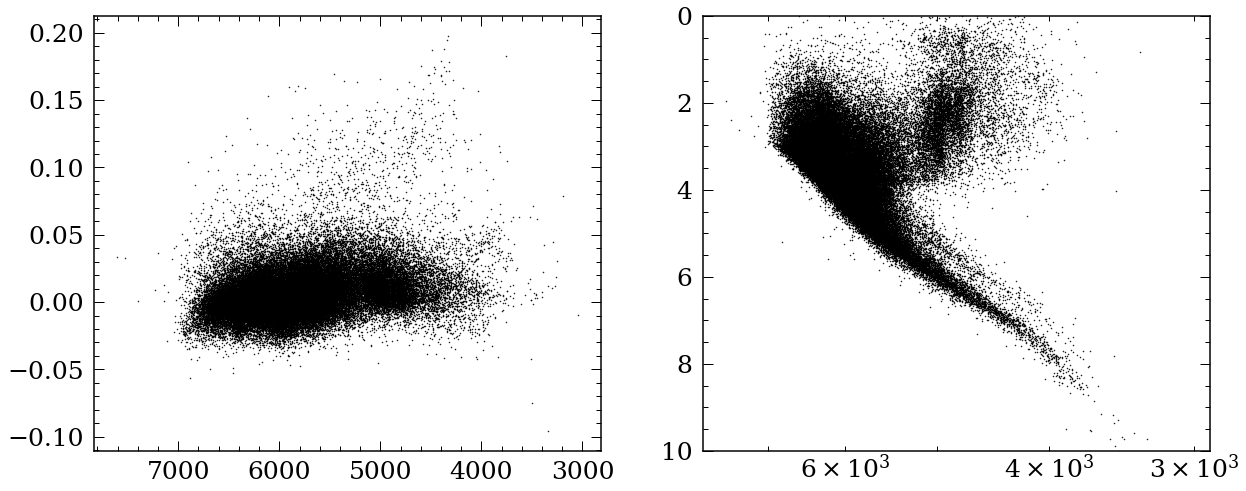

In [497]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(df['color_teffs'], df['activityindex_espcs'], 'k.', markersize=1)
#plt.xlim([3000,8000])
plt.gca().invert_xaxis()

plt.subplot(1,2,2)
plt.semilogx(df['color_teffs'],df['abs_G'],'k.',markersize=1)
df = df.sort_values(by='color_teffs').reset_index(drop=True)
plt.ylim([0,10])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()


In [498]:
"""plt.figure(figsize=(20,8))


plt.subplot(1,2,1)
plt.semilogx(df['color_teffs'],df['abs_G'],'k.',markersize=1)
df = df.sort_values(by='color_teffs').reset_index(drop=True)
absgsmooth = gaussian_filter(df['abs_G'].values, 100)

plt.semilogx(df['color_teffs'],absgsmooth-0.4,'r.',markersize=1)

m=df['abs_G']<absgsmooth-0.4
m=m&(df['abs_G']>4)

plt.semilogx(df['color_teffs'][m],df['abs_G'][m],'r.',markersize=1)
plt.ylim([0,10])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel('Temp')
plt.ylabel('abs_g')

plt.subplot(1,2,2)
df_nob = df[~m].reset_index(drop=True)
plt.semilogx(df_nob['color_teffs'],df_nob['abs_G'],'k.',markersize=1)
plt.ylim([0,10])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

print(len(df_nob))"""

"plt.figure(figsize=(20,8))\n\n\nplt.subplot(1,2,1)\nplt.semilogx(df['color_teffs'],df['abs_G'],'k.',markersize=1)\ndf = df.sort_values(by='color_teffs').reset_index(drop=True)\nabsgsmooth = gaussian_filter(df['abs_G'].values, 100)\n\nplt.semilogx(df['color_teffs'],absgsmooth-0.4,'r.',markersize=1)\n\nm=df['abs_G']<absgsmooth-0.4\nm=m&(df['abs_G']>4)\n\nplt.semilogx(df['color_teffs'][m],df['abs_G'][m],'r.',markersize=1)\nplt.ylim([0,10])\nplt.gca().invert_xaxis()\nplt.gca().invert_yaxis()\n\nplt.xlabel('Temp')\nplt.ylabel('abs_g')\n\nplt.subplot(1,2,2)\ndf_nob = df[~m].reset_index(drop=True)\nplt.semilogx(df_nob['color_teffs'],df_nob['abs_G'],'k.',markersize=1)\nplt.ylim([0,10])\nplt.gca().invert_xaxis()\nplt.gca().invert_yaxis()\n\nprint(len(df_nob))"

In [499]:
# APOCASK: https://arxiv.org/abs/1804.09983
ASstars = pd.read_csv('../NewGyroKineage/ASage.csv')
gaiakepler = readfits('../AgeBinary/kepler_dr3_1arcsec.fits')
ASstars = pd.merge(ASstars, gaiakepler, left_on='KIC',
                 right_on='kepid',how='inner').drop_duplicates(keep='first').reset_index(drop=True)



ASKICs = ASstars['KIC'].unique()
ASage = np.zeros(len(ASKICs))
ASage_err = np.zeros(len(ASKICs))
source_ds = np.zeros(len(ASKICs))
for i in range(len(ASKICs)):
    singstar = ASstars.loc[ASstars['KIC']==ASKICs[i]]
    source_ds[i] = singstar['source_id'].iloc[0]
    ASage_err[i] = max(singstar['Age'])-min(singstar['Age'])
    ASage[i] = np.mean(singstar['Age'])
ASages = pd.DataFrame(np.array((source_ds, ASKICs, ASage, ASage_err)).T, 
                      columns=['source_id','KIC','Age','Age_err'])
ASages = pd.merge(ASages, df, left_on='source_id', right_on='source_id',
                     how='inner').drop_duplicates(keep='first').reset_index(drop=True)
len(ASages), ASages.columns

(26,
 Index(['source_id', 'KIC', 'Age', 'Age_err', 'Unnamed: 0', 'solution_id',
        'designation', 'random_index', 'ref_epoch', 'ra',
        ...
        'bprp_dered', 'G_dered', 'abs_G', 'color_teffs', 'vx', 'vy', 'vz', 'x',
        'y', 'z'],
       dtype='object', length=177))

In [500]:
#APOCASK_cm = ASages.loc[ASages['Age_err']/ASages['Age']<0.15].reset_index(drop=True)
#len(APOCASK_cm)

APOCASK_cm = ASages
len(APOCASK_cm)

26

In [501]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point
    
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

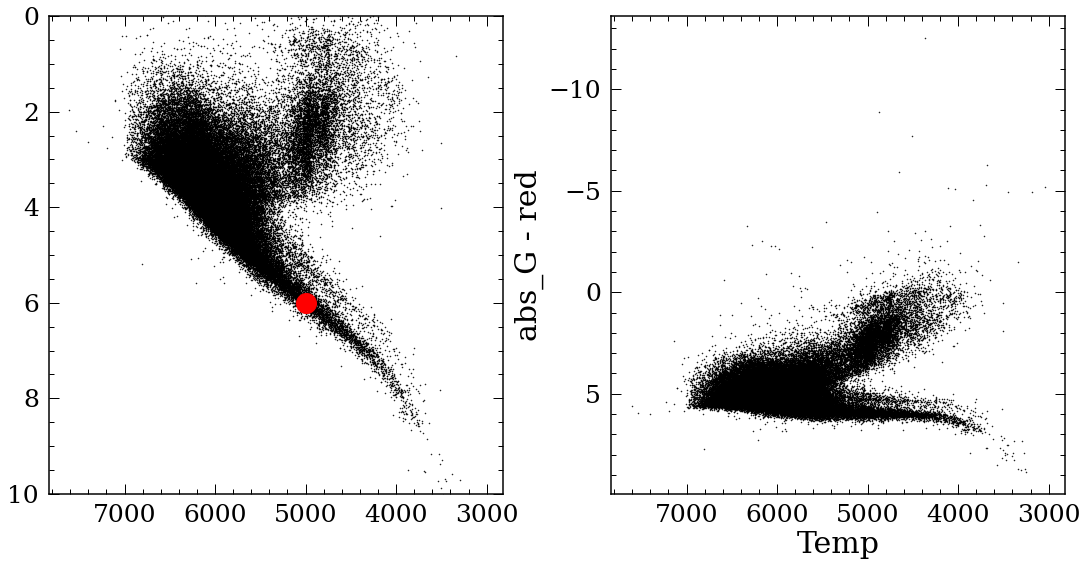

In [502]:
from scipy.ndimage import gaussian_filter
from scipy.spatial.transform import Rotation as R

plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(df['color_teffs'],df['abs_G'],'k.',markersize=1)
#plt.plot(clusterAS['teff_calc'], clusterAS['abs_G'],'ro')

plt.plot([5e3],[6],'ro',markersize=20)

df = df.sort_values(by='color_teffs').reset_index(drop=True)

"""
r = R.from_euler('xyz',(80,80,0), degrees=True) 
p_r=r.apply(np.array([df_nob['teff_calc'].values,df_nob['abs_G'].values,
                      np.zeros(len(df_nob))]).T) #Rotated points
"""

df['teff_rot'],df['abs_G_rot'] = rotate([5e3,6],[df['color_teffs'].values,df['abs_G'].values],0.0014)

plt.ylim([0,10])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.plot(df['teff_rot'],df['abs_G_rot'],'k.',markersize=1)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()


plt.xlabel('Temp')
plt.ylabel('abs_G - red')
plt.tight_layout()

In [503]:
df['KID'] = df['source_id']


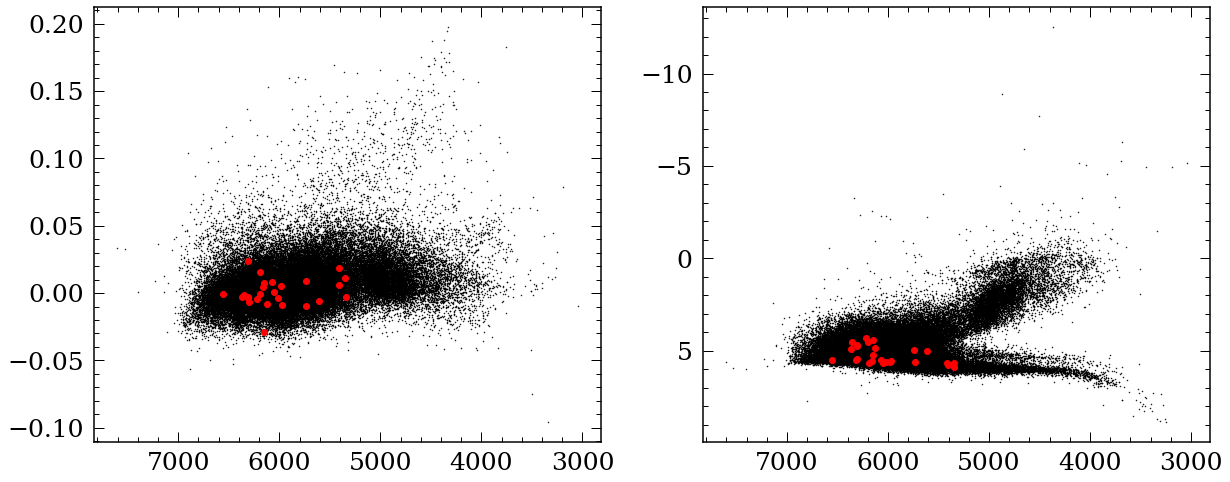

In [504]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(df['color_teffs'], df['activityindex_espcs'], 'k.', markersize=1)
plt.plot(APOCASK_cm['color_teffs'], APOCASK_cm['activityindex_espcs'], 'ro')
plt.gca().invert_xaxis()

plt.subplot(1,2,2)
plt.plot(df['teff_rot'], df['abs_G_rot'], 'k.', markersize=1)
APOCASK_cm['teff_rot'],APOCASK_cm['abs_G_rot'] = rotate([5e3,6],[APOCASK_cm['color_teffs'].values,APOCASK_cm['abs_G'].values],0.0014)
plt.plot(APOCASK_cm['teff_rot'], APOCASK_cm['abs_G_rot'], 'ro')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()



In [505]:
#df_nob = df_nob.drop_duplicates('source_id')
df = df.reset_index(drop=True)
APOCASK_cm = APOCASK_cm.reset_index(drop=True)


In [506]:
APOCASK_cm['KID'] = APOCASK_cm['source_id']


In [514]:
print(len(df))
df = df.dropna(subset=['teff_rot','abs_G_rot','activityindex_espcs','vz']).reset_index(drop=True)
df['activity_pos'] = df['activityindex_espcs']-min(df['activityindex_espcs'])

APOCASK_cm = APOCASK_cm.dropna(subset=['Age','Age_err']).reset_index(drop=True)
print(len(df))
print(len(APOCASK_cm))
df['logactiv'] = np.log10(df['activity_pos'])
opt_binsize, df_common, chisq = optimizeBins(df, APOCASK_cm, ['teff_rot','abs_G_rot','logactiv'],
                                             [1,0.001,0.001],[500,0.3,0.05],
                                             min_star=15,max_star=50000,
                                             df_match_name='Age',
                                             df_match_name_err='Age_err',vz='vz',
                                             bintestNo=10,errVals=False)


65420
65420
26


/opt/homebrew/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


"opt_binsize, df_common, chisq = optimizeBins(df, APOCASK_cm, ['teff_rot','abs_G_rot','logactiv'],\n                                             [1,0.001,0.001],[500,0.3,0.05],\n                                             min_star=15,max_star=50000,\n                                             df_match_name='Age',\n                                             df_match_name_err='Age_err',vz='vz',\n                                             bintestNo=10,errVals=False)"

In [525]:
df_common = pd.merge(df_common, df[['source_id','activityindex_espcs']],
                    left_on='KID',right_on='source_id',how='inner')
print(len(df_common))
opt_binsize, chisq


26


([222.77777777777777, 0.06744444444444445, 0.02277777777777778],
 3.651312237212085)

(0.6639501339972155, 0.0002170185897811778)

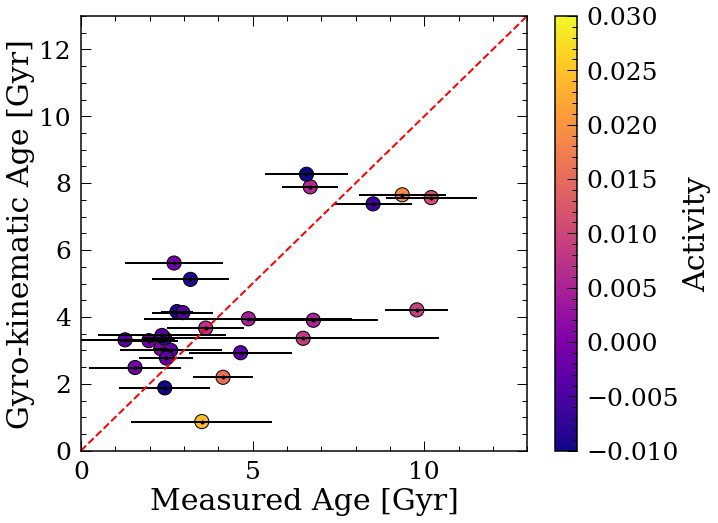

In [526]:


plt.figure(figsize=(10,8))
plt.errorbar(df_common['measure_age'],df_common['kin_age'],
             xerr=df_common['measure_age_err'],
             fmt='k.')

plt.scatter(df_common['measure_age'],df_common['kin_age'],
            c=df_common['activityindex_espcs'],
            s=200,edgecolor='k',vmin=-0.01,vmax=0.03,
           cmap='plasma')
cb = plt.colorbar()
cb.set_label('Activity')
plt.plot([0,13],[0,13],'r--')
plt.xlim([0,13])
plt.ylim([0,13])
plt.xlabel('Measured Age [Gyr]')
plt.ylabel('Gyro-kinematic Age [Gyr]')

scipy.stats.pearsonr(df_common['measure_age'], df_common['kin_age'])




In [517]:
df['vel_dis'],df['kin_age']=getkinAges(df,['teff_rot','abs_G_rot','logactiv'],
                                              opt_binsize,vz='vz',min_star=15,
                                               max_star=50000)




  0%|          | 0/65420 [00:00<?, ?it/s]<ipython-input-388-51b406805833>:165: RuntimeWarning: invalid value encountered in subtract
  mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
<ipython-input-388-51b406805833>:178: RuntimeWarning: invalid value encountered in subtract
  mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 65420/65420 [00:37<00:00, 1764.95it/s]

23409



<ipython-input-388-51b406805833>:50: RuntimeWarning: divide by zero encountered in log
  logt = np.polyval(coeffs, np.log(v))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
<ipython-input-388-51b406805833>:50: RuntimeWarning: divide by zero encountered in log
  logt = np.polyval(coeffs, np.log(v))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


Text(0, 0.5, 'M$_G$')

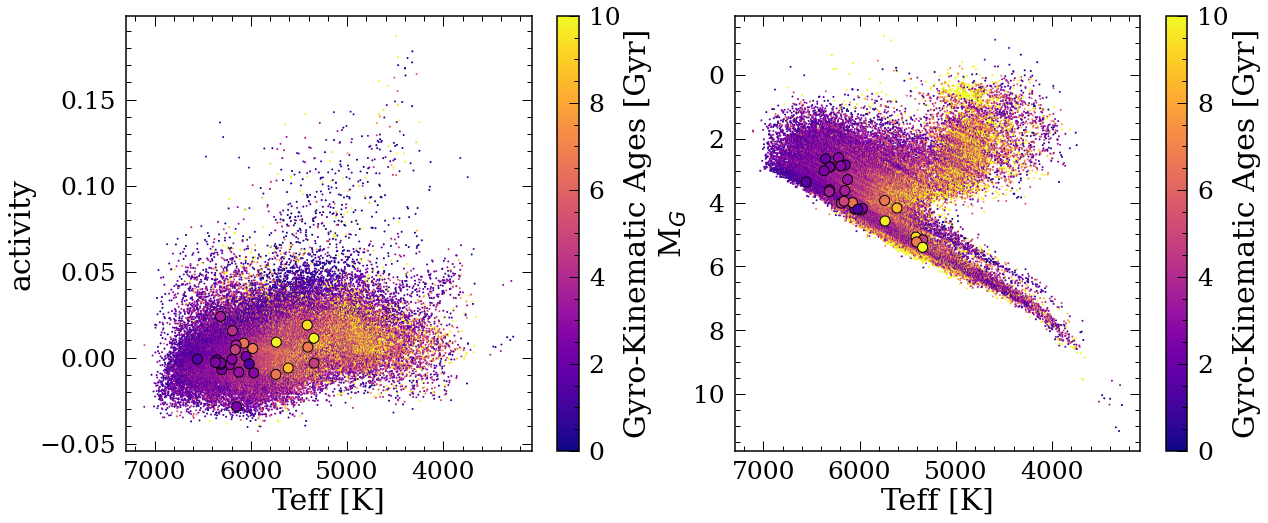

In [518]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.scatter(df['color_teffs'], df['activityindex_espcs'], c=df['kin_age'],s=1,
            vmin=0,vmax=10,cmap='plasma')
plt.scatter(APOCASK_cm['color_teffs'], APOCASK_cm['activityindex_espcs'], 
            c=APOCASK_cm['Age'],s=100,edgecolor='k',
           vmin=0,vmax=10,cmap='plasma')
plt.gca().invert_xaxis()
#plt.yscale('log')
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('activity')

plt.subplot(1,2,2)
plt.scatter(df['color_teffs'],df['abs_G'], c=df['kin_age'],s=1,
           vmin=0,vmax=10,cmap='plasma')
plt.scatter(APOCASK_cm['color_teffs'], APOCASK_cm['abs_G'], 
            c=APOCASK_cm['Age'],s=100,edgecolor='k',
           vmin=0,vmax=10,cmap='plasma')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('M$_G$')






Text(0, 0.5, 'M$_G$')

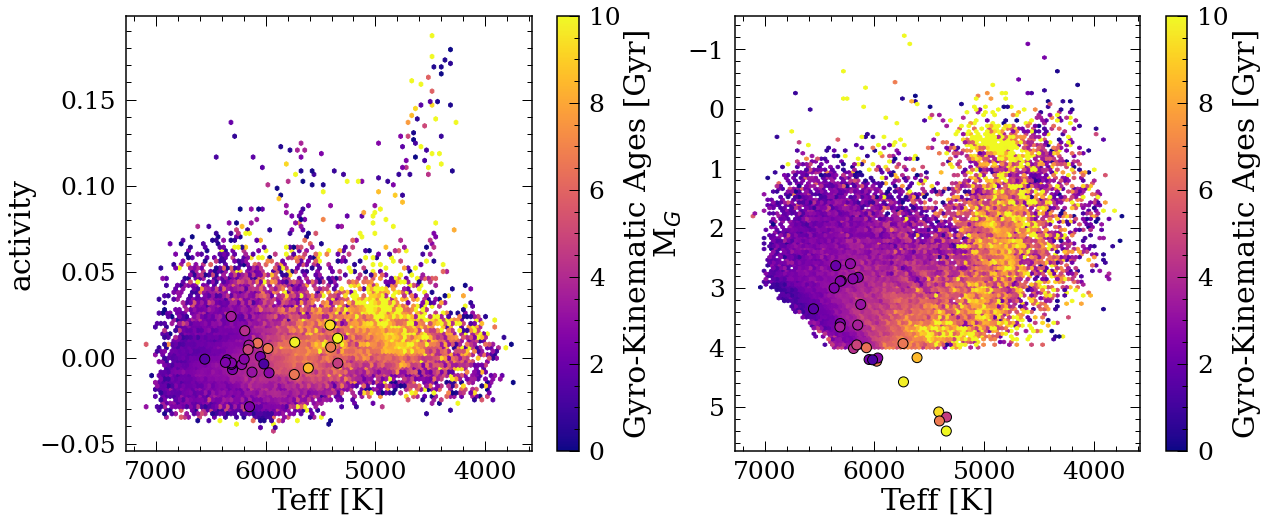

In [519]:
m = df['abs_G']<4
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.hexbin(df['color_teffs'][m], df['activityindex_espcs'][m], 
            C=df['kin_age'][m],
            vmin=0,vmax=10,cmap='plasma')
plt.scatter(APOCASK_cm['color_teffs'], APOCASK_cm['activityindex_espcs'], 
            c=APOCASK_cm['Age'],s=100,edgecolor='k',
           vmin=0,vmax=10,cmap='plasma')
plt.gca().invert_xaxis()
#plt.yscale('log')
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('activity')

plt.subplot(1,2,2)
plt.hexbin(df['color_teffs'][m],df['abs_G'][m], C=df['kin_age'][m],
           vmin=0,vmax=10,cmap='plasma')
plt.scatter(APOCASK_cm['color_teffs'], APOCASK_cm['abs_G'], 
            c=APOCASK_cm['Age'],s=100,edgecolor='k',
           vmin=0,vmax=10,cmap='plasma')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('M$_G$')







Text(0, 0.5, 'M$_G$')

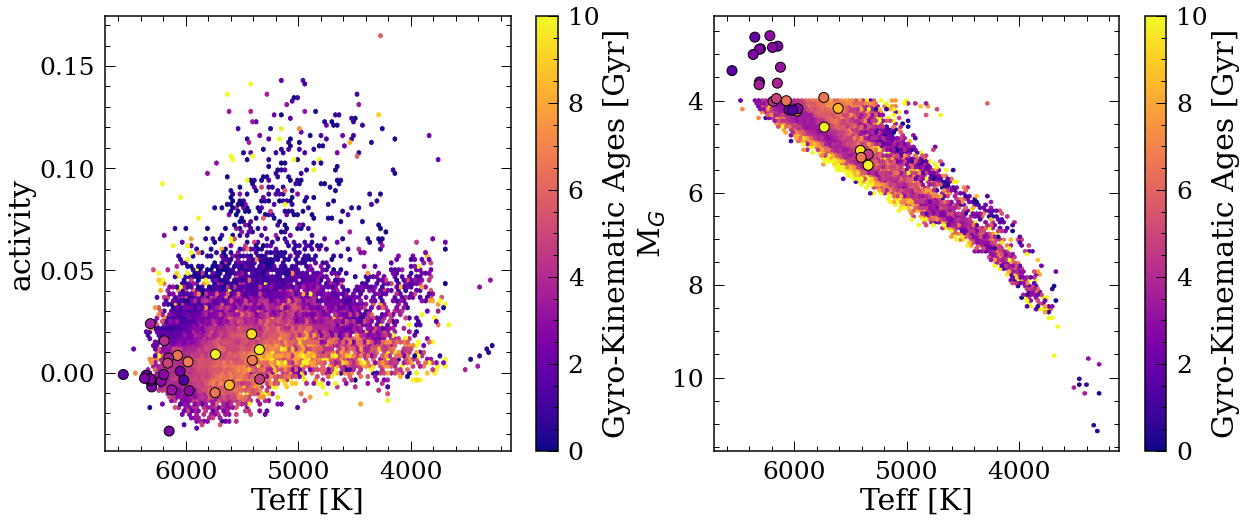

In [520]:
m = df['abs_G']>4
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.hexbin(df['color_teffs'][m], df['activityindex_espcs'][m], 
            C=df['kin_age'][m],
            vmin=0,vmax=10,cmap='plasma')
plt.scatter(APOCASK_cm['color_teffs'], APOCASK_cm['activityindex_espcs'], 
            c=APOCASK_cm['Age'],s=100,edgecolor='k',
           vmin=0,vmax=10,cmap='plasma')
plt.gca().invert_xaxis()
#plt.yscale('log')
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('activity')

plt.subplot(1,2,2)
plt.hexbin(df['color_teffs'][m],df['abs_G'][m], C=df['kin_age'][m],
           vmin=0,vmax=10,cmap='plasma')
plt.scatter(APOCASK_cm['color_teffs'], APOCASK_cm['abs_G'], 
            c=APOCASK_cm['Age'],s=100,edgecolor='k',
           vmin=0,vmax=10,cmap='plasma')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('M$_G$')








Text(0, 0.5, 'M$_G$')

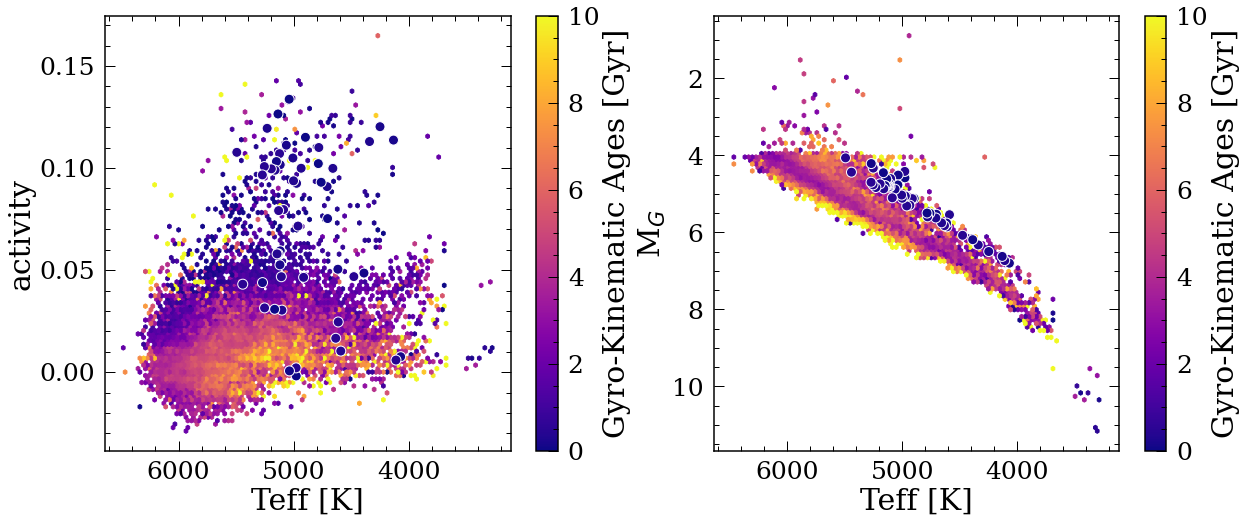

In [521]:
m = df['abs_G']>4


df = df.sort_values(by='color_teffs').reset_index(drop=True)
absgsmooth = gaussian_filter(df['abs_G'].values[m], 100)



m2 = df['kin_age'][m]<0.5
m2 = m2&(df['abs_G'][m]<(absgsmooth-0.5))

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.hexbin(df['color_teffs'][m], df['activityindex_espcs'][m], 
            C=df['kin_age'][m],
            vmin=0,vmax=10,cmap='plasma')
plt.scatter(df['color_teffs'][m][m2], df['activityindex_espcs'][m][m2], 
            c=df['kin_age'][m][m2],s=100,edgecolor='w', 
           vmin=0,vmax=10,cmap='plasma')
plt.gca().invert_xaxis()
#plt.yscale('log')
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('activity')

plt.subplot(1,2,2)
plt.hexbin(df['color_teffs'][m],df['abs_G'][m], C=df['kin_age'][m],
           vmin=0,vmax=10,cmap='plasma')
plt.scatter(df['color_teffs'][m][m2], df['abs_G'][m][m2], 
            c=df['kin_age'][m][m2],s=100,edgecolor='w', 
            vmin=0,vmax=10,cmap='plasma')

#plt.plot(df['color_teffs'][m],absgsmooth-0.4,'r.',markersize=1)

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('M$_G$')









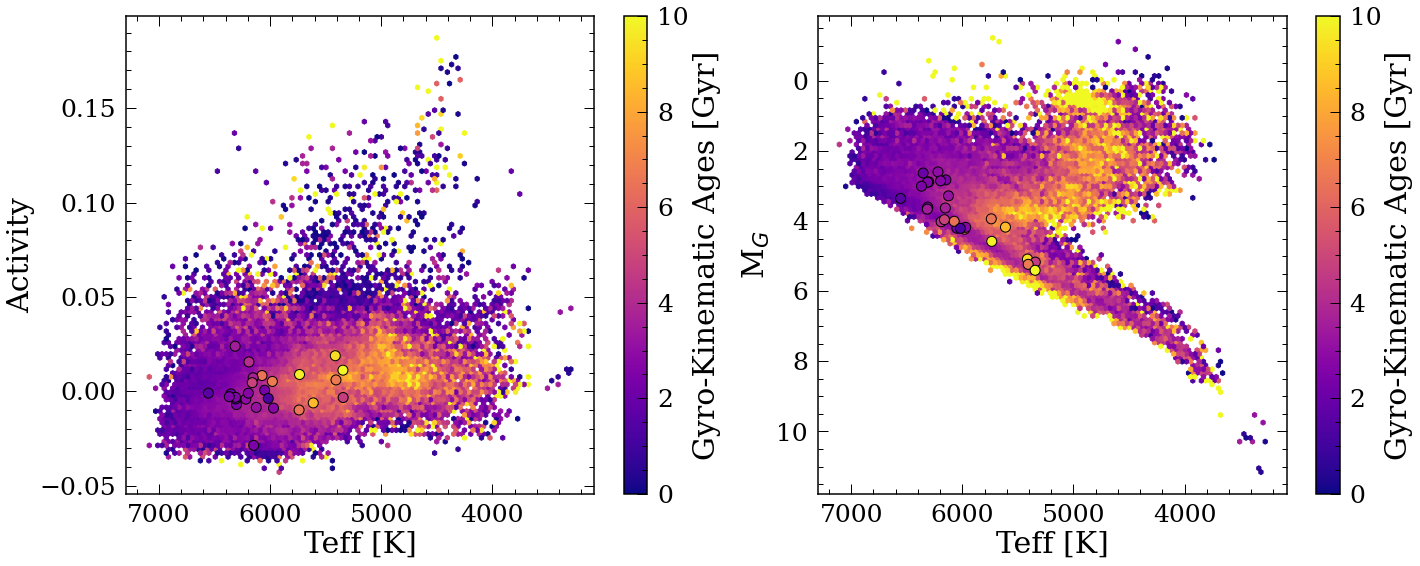

In [522]:
plt.figure(figsize=(20,8))
#df = df.loc[df['activityindex_espcs']>0]
plt.subplot(1,2,1)
plt.hexbin(df['color_teffs'], df['activityindex_espcs'], C=df['kin_age'],
            vmin=0,vmax=10,cmap='plasma')
plt.scatter(APOCASK_cm['color_teffs'], APOCASK_cm['activityindex_espcs'], 
            c=APOCASK_cm['Age'],s=100,edgecolor='k',
           vmin=0,vmax=10,cmap='plasma')
plt.gca().invert_xaxis()
#plt.yscale('log')
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('Activity')

plt.subplot(1,2,2)
plt.hexbin(df['color_teffs'],df['abs_G'], C=df['kin_age'],
           vmin=0,vmax=10,cmap='plasma')
plt.scatter(APOCASK_cm['color_teffs'], APOCASK_cm['abs_G'], 
            c=APOCASK_cm['Age'],s=100,edgecolor='k',
           vmin=0,vmax=10,cmap='plasma')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('M$_G$')



plt.tight_layout()



In [523]:
df.to_csv('Activity_age.csv', index=False)

# only use activity

In [427]:
print(len(df))
df = df.dropna(subset=['teff_rot','abs_G_rot','activityindex_espcs','vz']).reset_index(drop=True)
APOCASK_cm = APOCASK_cm.dropna(subset=['Age','Age_err']).reset_index(drop=True)
print(len(df))
print(len(APOCASK_cm))
df = df.loc[df['activityindex_espcs']>0].reset_index(drop=True)
df['logactiv'] = np.log10(df['activityindex_espcs'])
opt_binsize, df_common, chisq = optimizeBins(df, APOCASK_cm, ['teff_rot','logactiv'],
                                             [10,0.001],[500,1],
                                             min_star=15,max_star=50000,
                                             df_match_name='Age',
                                             df_match_name_err='Age_err',vz='vz',
                                             bintestNo=10,errVals=False)



39394
39394
26


  0%|          | 0/100 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
/opt/homebrew/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
100%|██████████| 11/11 [00:00<00:00, 3212.68it/s]


In [428]:
df_common = pd.merge(df_common, df[['source_id','activityindex_espcs']],
                    left_on='KID',right_on='source_id',how='inner')
print(len(df_common))
opt_binsize, chisq



11


([10.0, 0.334], 4.7909263760110825)

(0.8664185700242811, 0.0005598469740786096)

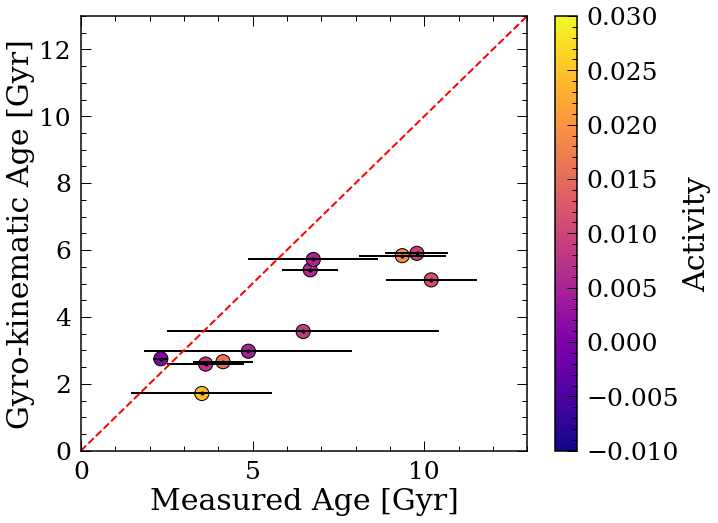

In [429]:


plt.figure(figsize=(10,8))
plt.errorbar(df_common['measure_age'],df_common['kin_age'],
             xerr=df_common['measure_age_err'],
             fmt='k.')

plt.scatter(df_common['measure_age'],df_common['kin_age'],
            c=df_common['activityindex_espcs'],
            s=200,edgecolor='k',vmin=-0.01,vmax=0.03,
           cmap='plasma')
cb = plt.colorbar()
cb.set_label('Activity')
plt.plot([0,13],[0,13],'r--')
plt.xlim([0,13])
plt.ylim([0,13])
plt.xlabel('Measured Age [Gyr]')
plt.ylabel('Gyro-kinematic Age [Gyr]')

scipy.stats.pearsonr(df_common['measure_age'], df_common['kin_age'])





In [430]:
df['vel_dis'],df['kin_age']=getkinAges(df,['teff_rot','logactiv'],
                                              opt_binsize,vz='vz',min_star=15,
                                               max_star=50000)





100%|██████████| 39394/39394 [00:08<00:00, 4901.60it/s]

7032



<ipython-input-388-51b406805833>:50: RuntimeWarning: divide by zero encountered in log
  logt = np.polyval(coeffs, np.log(v))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


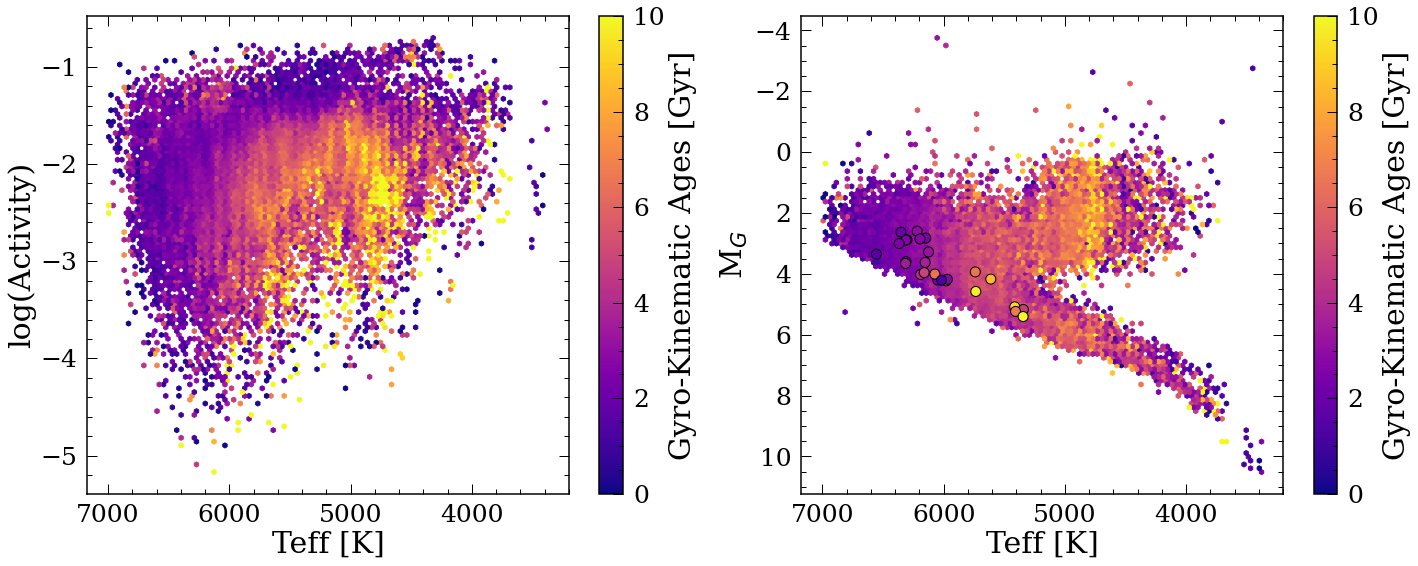

In [431]:
plt.figure(figsize=(20,8))
df = df.loc[df['activityindex_espcs']>0]
plt.subplot(1,2,1)
plt.hexbin(df['color_teffs'], df['logactiv'], C=df['kin_age'],
            vmin=0,vmax=10,cmap='plasma',gridsize=100)
"""plt.scatter(APOCASK_cm['color_teffs'], APOCASK_cm['activityindex_espcs'], 
            c=APOCASK_cm['Age'],s=100,edgecolor='k',
           vmin=0,vmax=10,cmap='plasma')"""
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('log(Activity)')

plt.subplot(1,2,2)
plt.hexbin(df['color_teffs'],df['abs_G'], C=df['kin_age'],
           vmin=0,vmax=10,cmap='plasma',gridsize=100)
plt.scatter(APOCASK_cm['color_teffs'], APOCASK_cm['abs_G'], 
            c=APOCASK_cm['Age'],s=100,edgecolor='k',
           vmin=0,vmax=10,cmap='plasma')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('M$_G$')



plt.tight_layout()





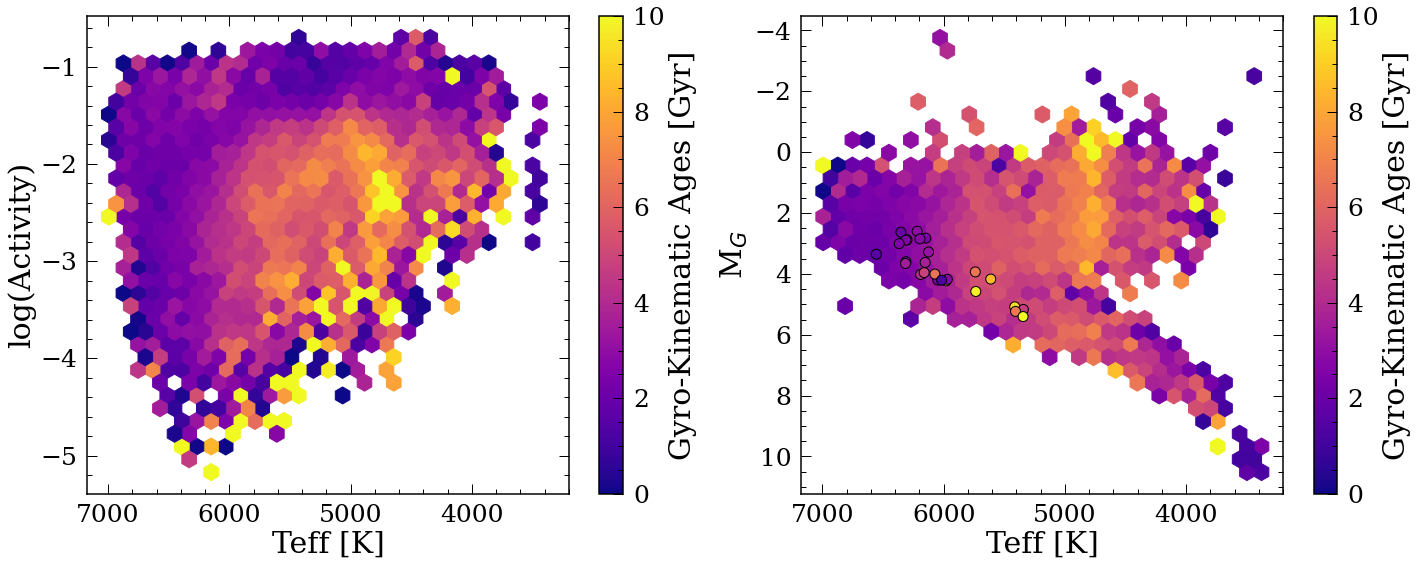

In [328]:
plt.figure(figsize=(20,8))
df = df.loc[df['activityindex_espcs']>0]
plt.subplot(1,2,1)
plt.hexbin(df['color_teffs'], df['logactiv'], C=df['kin_age'],
            vmin=0,vmax=10,cmap='plasma',gridsize=30)
"""plt.scatter(APOCASK_cm['color_teffs'], APOCASK_cm['activityindex_espcs'], 
            c=APOCASK_cm['Age'],s=100,edgecolor='k',
           vmin=0,vmax=10,cmap='plasma')"""
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('log(Activity)')

plt.subplot(1,2,2)
plt.hexbin(df['color_teffs'],df['abs_G'], C=df['kin_age'],
           vmin=0,vmax=10,cmap='plasma',gridsize=30)
plt.scatter(APOCASK_cm['color_teffs'], APOCASK_cm['abs_G'], 
            c=APOCASK_cm['Age'],s=100,edgecolor='k',
           vmin=0,vmax=10,cmap='plasma')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('M$_G$')



plt.tight_layout()




# rotation kinematic ages

In [408]:
prot_kinage = pd.read_pickle('new_age_ztf_santos.pkl')
prot_kinage = prot_kinage.dropna(subset=['source_id'])
prot_kinage['source_id'] = np.array(prot_kinage['source_id'], dtype=int)

df_prot = pd.merge(df, prot_kinage[['source_id','kin_age','Prot']],
                  left_on='source_id', right_on='source_id', how='inner')

df_prot


,Unnamed: 0,solution_id,designation,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,y,z,teff_rot,abs_G_rot,KID,logactiv,vel_dis,kin_age_x,kin_age_y,Prot
0,15506,1636148068921376768,Gaia DR3 2133182334618950656,7314643,2016.0,289.921346,0.074280,50.893481,0.079001,8.124722,...,0.116881,0.035056,4362.754116,5.854589,2133182334618950656,-1.922164,23.566517,8.826410,2.447161,34.94
1,12774,1636148068921376768,Gaia DR3 2075122416960890624,1672512087,2016.0,299.033973,0.214831,40.926825,0.231386,7.454654,...,0.129366,0.014944,4423.229823,5.702711,2075122416960890624,-1.540711,0.000000,NaN,1.461062,30.42
2,13535,1636148068921376768,Gaia DR3 2117319031828326144,317350487,2016.0,281.387763,0.069745,44.379610,0.088839,5.559469,...,0.162578,0.060304,4545.703324,5.915122,2117319031828326144,-1.606408,9.432756,2.086551,2.084583,14.69
3,26349,1636148068921376768,Gaia DR3 2107479124313135616,134610625,2016.0,282.801605,0.008927,46.365802,0.009881,6.352644,...,0.144115,0.052048,4550.981628,5.949285,2107479124313135616,-2.698990,38.072832,18.789347,2.562724,32.37
4,23702,1636148068921376768,Gaia DR3 2105528350169042688,26425349,2016.0,285.872830,0.022359,42.724921,0.023753,6.463154,...,0.142409,0.042550,4559.960745,5.857927,2105528350169042688,-1.614325,14.249269,3.995923,1.743119,16.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,22351,1636148068921376768,Gaia DR3 2106242620409806592,1680689011,2016.0,287.263154,0.011012,45.046525,0.012545,2.096325,...,0.444756,0.130901,6742.493153,5.623971,2106242620409806592,-2.740184,10.478982,2.462527,NaN,0.74
2151,22721,1636148068921376768,Gaia DR3 2106382941281094656,384494396,2016.0,285.749626,0.009564,45.027890,0.010513,1.329662,...,0.696288,0.218757,6759.182666,5.363014,2106382941281094656,-2.898632,6.548237,1.174224,NaN,1.31
2152,56031,1636148068921376768,Gaia DR3 2080471201728842496,183186478,2016.0,295.064751,0.012996,46.499808,0.014328,4.026493,...,0.239240,0.049979,6777.446392,5.579226,2080471201728842496,-1.916387,5.125567,0.798337,NaN,2.41
2153,51907,1636148068921376768,Gaia DR3 2127165429032994304,225594573,2016.0,288.833830,0.011486,45.038553,0.013645,2.536852,...,0.370052,0.101382,6808.328159,5.552854,2127165429032994304,-2.897733,11.461709,2.835964,NaN,1.35


(0.22662118567732414, 2.791683551022617e-22)

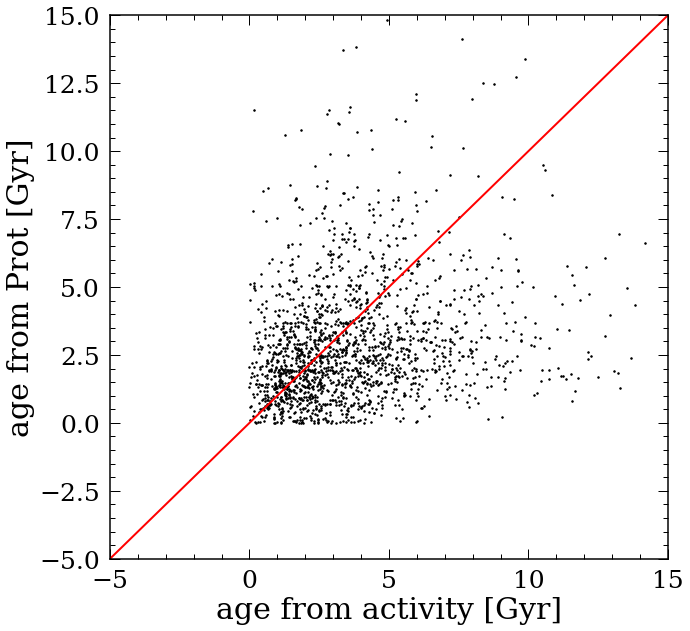

In [409]:
import scipy.stats
df_prot = df_prot.dropna(subset=['kin_age_x', 'kin_age_y'])
plt.plot(df_prot['kin_age_x'], df_prot['kin_age_y'], 'k.', markersize=3)
plt.plot([-5,15], [-5,15], 'r-')
plt.xlim([-5,15])
plt.ylim([-5,15])
plt.xlabel('age from activity [Gyr]')
plt.ylabel('age from Prot [Gyr]')
scipy.stats.pearsonr(df_prot['kin_age_x'], df_prot['kin_age_y'])


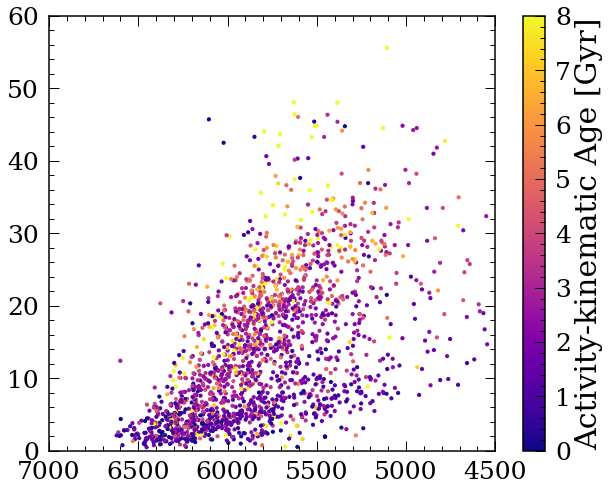

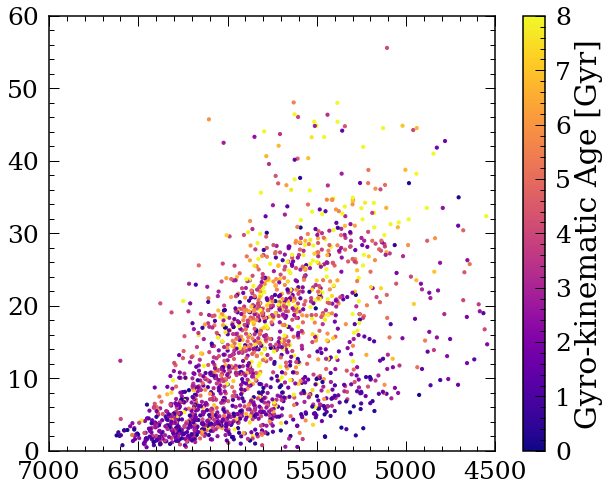

In [423]:
plt.figure(figsize=(10,8))
plt.scatter(df_prot['color_teffs'], df_prot['Prot'], c=df_prot['kin_age_y'],vmin=0,
           vmax=8,cmap='plasma',s=10)
plt.ylim([0,60])
plt.xlim([7000,4500])
cb = plt.colorbar()
cb.set_label('Activity-kinematic Age [Gyr]')

plt.figure(figsize=(10,8))
plt.scatter(df_prot['color_teffs'], df_prot['Prot'], c=df_prot['kin_age_x'],vmin=0,
           vmax=8,cmap='plasma',s=10)
plt.ylim([0,60])
plt.xlim([7000,4500])
cb = plt.colorbar()
cb.set_label('Gyro-kinematic Age [Gyr]')

# Add metallicity

In [369]:
rvs = readfits('RVSdr3.fits')
len(df), len(rvs)

(39394, 999645)

In [385]:
rvs['source_id'] = np.array(rvs['source_id'], dtype=int)
rvs['teff'] = np.array(rvs['teff'], dtype=float)
rvs['m_h'] = np.array(rvs['m_h'], dtype=float)

In [386]:
df = pd.merge(df, rvs, left_on='source_id', right_on='source_id', how='inner')
len(df)

3286

In [387]:
df['source_id']

0       2053436031868774912
1       2053448946827150336
2       2053451699909566208
3       2053458331339758848
4       2053461522493581056
               ...         
3281    4611374959715945344
3282    4609482704502812928
3283    4606977467259035648
3284    4609645496644971008
3285    4610009920328729088
Name: source_id, Length: 3286, dtype: int64